# Machine Learning Model on Credit Score Data Using Pipelines and Hyperparameter Tuning

## Import Libraries

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Data Input

In [22]:
# Link to dataset: kaggle.com/datasets/sujithmandala/credit-score-classification-dataset/data
# This is a dataset on creditscores (classified as High, Average, or Low)
# as predicted by features like income, marital status, education, etc.

In [23]:
df = pd.read_csv('creditscore.csv')

## Data Processing

In [24]:
# Display the imported data
print(df)

     Age  Gender  Income            Education Marital Status  \
0     25  Female   50000    Bachelor's Degree         Single   
1     30    Male  100000      Master's Degree        Married   
2     35  Female   75000            Doctorate        Married   
3     40    Male  125000  High School Diploma         Single   
4     45  Female  100000    Bachelor's Degree        Married   
..   ...     ...     ...                  ...            ...   
159   29  Female   27500  High School Diploma         Single   
160   34    Male   47500   Associate's Degree         Single   
161   39  Female   62500    Bachelor's Degree        Married   
162   44    Male   87500      Master's Degree         Single   
163   49  Female   77500            Doctorate        Married   

     Number of Children Home Ownership Credit Score  
0                     0         Rented         High  
1                     2          Owned         High  
2                     1          Owned         High  
3              

In [25]:
# There are no null values in this dataset.
print(df.isnull().sum())

Age                   0
Gender                0
Income                0
Education             0
Marital Status        0
Number of Children    0
Home Ownership        0
Credit Score          0
dtype: int64


In [26]:
# This data requires encoding of categorical features.
# Some features are ordered, and so both encoding methods are needed.
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

In [27]:
#Map 'Credit Score' values.
#70% of the values are 'High', so we combine 'Average' and 'Low' into the same value ('Not High')
score_mapping = {'High': 1, 'Average': 0, 'Low': 0}
df['Credit Score'] = df['Credit Score'].map(score_mapping)

# ColumnTransformer for categorical features
ct = ColumnTransformer([
    ('ohe', OneHotEncoder(), ['Gender', 'Marital Status', 'Home Ownership']),
    ('ordinal', OrdinalEncoder(), ['Education'])
], remainder='passthrough')

transformed_data = ct.fit_transform(df)

# Get the transformed columns' names
ohe_feature_names = ct.named_transformers_['ohe'].get_feature_names_out(['Gender', 'Marital Status', 'Home Ownership'])
transformed_feature_names = list(ohe_feature_names) + ['Education']
untransformed_columns = [col for col in df.columns if col not in ['Gender', 'Marital Status', 'Home Ownership', 'Education']]
all_feature_names = transformed_feature_names + untransformed_columns

df = pd.DataFrame(transformed_data, columns=all_feature_names)

df.head()

,Gender_Female,Gender_Male,Marital Status_Married,Marital Status_Single,Home Ownership_Owned,Home Ownership_Rented,Education,Age,Income,Number of Children,Credit Score
0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,25.0,50000.0,0.0,1.0
1,0.0,1.0,1.0,0.0,1.0,0.0,4.0,30.0,100000.0,2.0,1.0
2,1.0,0.0,1.0,0.0,1.0,0.0,2.0,35.0,75000.0,1.0,1.0
3,0.0,1.0,0.0,1.0,1.0,0.0,3.0,40.0,125000.0,0.0,1.0
4,1.0,0.0,1.0,0.0,1.0,0.0,1.0,45.0,100000.0,3.0,1.0


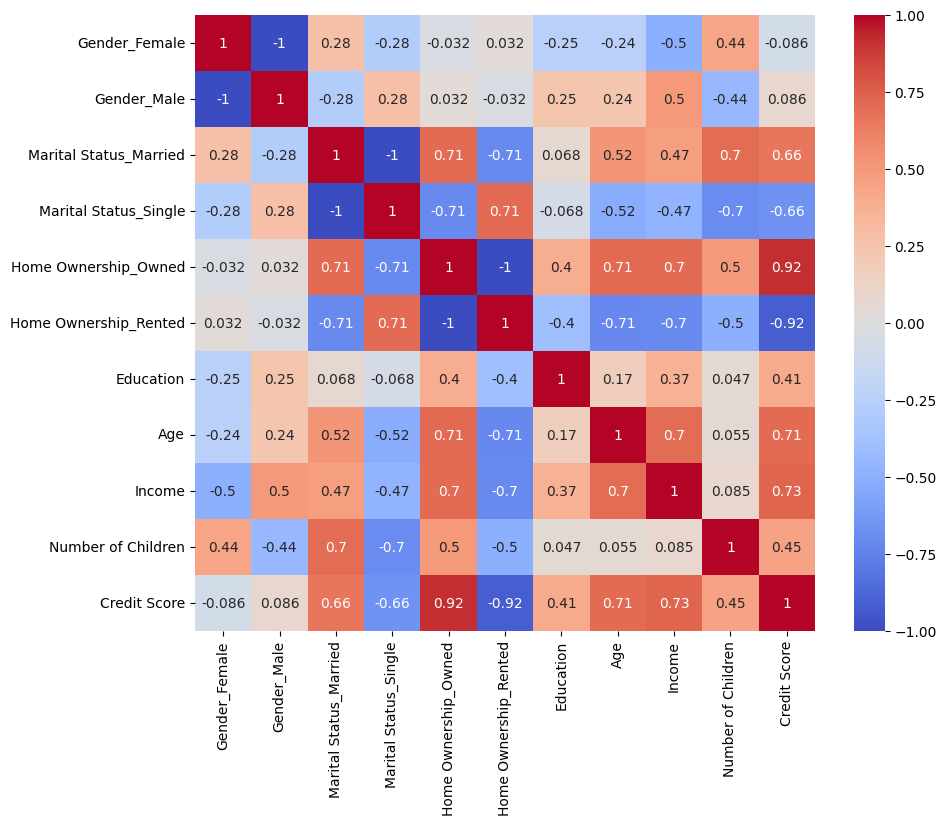

In [28]:
# Heatmap

plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot = True, cmap ='coolwarm')
plt.show()

### Remarks

There are no missing or null values in the dataset. If there were missing values, the method to replace them would depend on the context. For values like income, I would consider replacing the null values with the mean value for the column. For the categorical data, which makes up most of the features, it doesn't seem to be appropriate to replace them with arbitrary values. I would likely drop the rows that had incomplete categorical features. If the column had many null values, say greater than 1/3 of the values are null, then the entire column would have been dropped.

The data is numerical and categorical, with categorical features outnumbering numerical ones. This necessarily requires encoding. In this case, one-hot encoding is acceptable for every category except education level, which used ordinal encoding.

## Implement Models

In [29]:
# Import ML Libraries

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, accuracy_score, f1_score

In [30]:
# Prepare X (features) and y (target)

X = df.drop(columns=['Credit Score'])
y = df['Credit Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

In [31]:
# Prepare Pipelines

lr_pipeline = Pipeline([
    ('classifier', LogisticRegression())
])

rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier())
])

knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', KNeighborsClassifier())
])

In [32]:
# Prepare parameters to test

param_grid_lr = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l2']
}

param_grid_rf = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [10, 20, 30],
    'classifier__max_features': ['sqrt', 'log2']
}

param_grid_knn = {
    'classifier__n_neighbors': [3, 5, 7, 9, 11],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan', 'minkowski']
}

In [33]:
# Use accuracy and f1_score as scoring metrics

scoring = {
    'f1_score': make_scorer(f1_score)
}

In [34]:
# Perform Grid Search

grid_search_lr = GridSearchCV(lr_pipeline, param_grid_lr, cv=5, scoring=scoring, refit='f1_score')
grid_search_rf = GridSearchCV(rf_pipeline, param_grid_rf, cv=5, scoring=scoring, refit='f1_score')
grid_search_knn = GridSearchCV(knn_pipeline, param_grid_knn, cv=5, scoring=scoring, refit='f1_score')

grid_search_lr.fit(X_train, y_train)
grid_search_rf.fit(X_train, y_train)
grid_search_knn.fit(X_train, y_train)

/Users/henryzhao/anaconda3/envs/devenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/henryzhao/anaconda3/envs/devenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

In [ ]:
# Display F1_Score for the best parameters

best_params_lr = grid_search_lr.best_params_
best_params_rf = grid_search_rf.best_params_
best_params_knn = grid_search_knn.best_params_

best_f1_lr = grid_search_lr.best_score_
best_f1_rf = grid_search_rf.best_score_
best_f1_knn = grid_search_knn.best_score_

print("\nBest Parameters for Logistic Regression based on F1:", best_params_lr)
print("Best F1 Score for Logistic Regression:", best_f1_lr)
print("\nBest Parameters for Random Forest based on F1:", best_params_rf)
print("Best F1 Score for Random Forest:", best_f1_rf)
print("\nBest Parameters for KNN based on F1:", best_params_knn)
print("Best F1 Score for KNN:", best_f1_knn)


Best Parameters for Logistic Regression based on F1: {'classifier__C': 1, 'classifier__penalty': 'l2'}
Best F1 Score for Logistic Regression: 0.9831660231660232

Best Parameters for Random Forest based on F1: {'classifier__max_depth': 10, 'classifier__max_features': 'log2', 'classifier__n_estimators': 50}
Best F1 Score for Random Forest: 0.9828197028197028

Best Parameters for KNN based on F1: {'classifier__metric': 'euclidean', 'classifier__n_neighbors': 3, 'classifier__weights': 'uniform'}
Best F1 Score for KNN: 0.9713997113997113


### Remarks

The dataset requires classification, as the target values are either 'High' (1) or 'Not High' (0).

The following models were chosen: 
- Logistic Regression is a fast and easy model for binary classification that we can compare other models' results to. However, it is linear, and the data may not be linear.
- KNN was also used as a quick and simple model. The dataset was relatively small so KNN seemed appropriate.
- Random Forest seemed appropriate because this dataset contains a mixture of numerical and categorical data. It is also advantageous in that it is somewhat resilient to overfitting. It can handle linear and non-linear data well. This model took by far the longest to complete computation.

For the best model, it was very close between Random Forest (F1 = 0.9771) and KNN (F1 = 0.9714). Logistic Regression was worse than either with an F1 slightly above 0.90. This is suggests that the data may be less well described by a linear model, as LR is the only linear model of the three. Random Forest performing the best is expected, since it is much better than the other two at handling a mix of numerical and categorical data types.

## Model Validation

In [ ]:
test_accuracy_lr = grid_search_lr.score(X_test, y_test)
test_accuracy_rf = grid_search_rf.score(X_test, y_test)
test_accuracy_knn = grid_search_knn.score(X_test, y_test)

results = {
    'Algorithm': ['Logistic Regression', 'Random Forest', 'KNN'],
    'Test Accuracy': [test_accuracy_lr, test_accuracy_rf, test_accuracy_knn]
}

results = pd.DataFrame(results)
print(results)

             Algorithm  Test Accuracy
0  Logistic Regression       1.000000
1        Random Forest       1.000000
2                  KNN       0.980392



### Remarks

The accuracy metric used here is the test accuracy, which represents the proportion of correct predictions made by the model on the test dataset. This metric is straightforward and widely used for classification and is suitable here for a simple, relatively low-stakes binary classification.

LR achieved an accuracy of 0.90, which is high, but trailing behind KNN and Random Forest. This suggests all models had good generalization. Random Forest's perfect acccuracy is concerning. This suggests perfect generalization, which indicates overfitting.

The Random Forest model achieved a perfect accuracy on the test data. Although an "ideal" result, this highly suggests some level of overfitting. Both KNN and Logistic Regression have high enough accuracies to be valuable in the real world, perhaps in research applications. However, LR would not be suitable for a high-stakes application, for example, in a situation where a bank may be seeking to achieve a level of profit by predicting credit scores, an accuracy of 0.9016 is insufficient. KNN is more suitable as it has a very high score.

For future improvement, more extensive feature engineering could be done. Additional models could be considered, such as SVM and Gradient Boost.